In [1]:
import numpy as np
from qiskit import QuantumCircuit

import qiskit_aer.noise as noise
from qiskit.quantum_info import Operator
from qiskit.circuit.library import get_standard_gate_name_mapping as gate_map

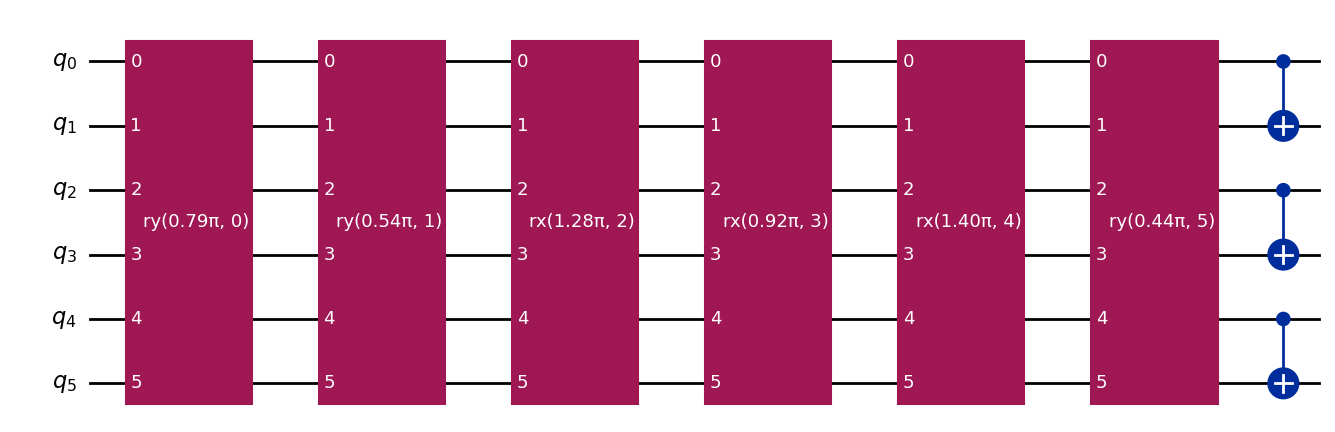

In [23]:
# Define the number of qubits
num_qubits = 6

# Define noise-coupling matrix with gamma values (example values)
gamma_matrix = np.zeros((num_qubits, num_qubits))
gamma_matrix[0, 1] = 0.025  # γ_0->1
gamma_matrix[1, 2] = 0.025  # γ_1->2
gamma_matrix[2, 3] = 0.025  # γ_2->3
gamma_matrix[3, 2] = 0.025  # γ_3->2
gamma_matrix[4, 3] = 0.025  # γ_4->3
gamma_matrix[5, 4] = 0.025  # γ_5->4

# Define parameters for U(phi) gates
phi_rotation_values = np.pi * np.array([0.25, 0.5, 0.75, 1])
# phi_arr = np.random.choice(phi_rotation_values, size=num_qubits)
phi_arr = np.random.uniform(0, 2 * np.pi, size=num_qubits)
# gate_types = ['RY', 'RY', 'RX', 'RX', 'RX', 'RY']
sq_gates = {  # {qubit: gate_type}
    0: 'ry',
    1: 'ry',
    2: 'rx',
    3: 'rx',
    4: 'rx',
    5: 'ry'
}

# Create the quantum circuit
qc = QuantumCircuit(num_qubits)
for i in range(num_qubits):
    gate_name = sq_gates[i]
    phi_in_pi = phi_arr[i] / np.pi
    gate_op = Operator.from_label("I" * num_qubits)
    gate_op = gate_op.compose(Operator(type(gate_map()[gate_name])(phi_arr[i])), qargs=[i])
    custom_gate_label = f"{gate_name}({phi_in_pi:.2f}π, {i})"
    # if i + 1 < num_qubits:

    qc.unitary(gate_op, range(num_qubits), label=custom_gate_label)

for i in range(0, num_qubits - 1, 2):
    # Add CX gates for pairs (0, 1), (2, 3), etc
    qc.cx(i, i + 1)

# Display the circuit structure
qc.draw("mpl")

In [27]:
from qiskit.circuit import Gate


def create_custom_noise_model_from_circuit(circuit: QuantumCircuit, phi_arr, gamma_matrix):
    noise_model = noise.NoiseModel()
    num_qubits = circuit.num_qubits
    # Loop through all pairs based on gamma_matrix and check for custom gates
    for instruction in circuit.data:
        # Extract gate type, target qubits, and rotation angle (phi)
        gate: Gate = instruction.operation
        if gate.label is not None:
            main_qubit_index = int(gate.label[-2])  # Extract the main qubit from the gate label (e.g., 'ry(0.25π, 0)')
            gate_name = gate.label[:2]  # Extract the gate name from the label (e.g., 'ry')
            gate_type = type(gate_map()[gate_name])  # Get the gate type from the gate name
            phi = phi_arr[main_qubit_index]  # Rotation angle of original gate

            # Construct the noise operator based on the gate type
            noise_op = Operator.from_label("I" * num_qubits)
            for j in range(num_qubits):
                if gamma_matrix[main_qubit_index, j] != 0:
                    noise_rotation_op = Operator(gate_type(gamma_matrix[main_qubit_index, j] * phi))
                    noise_op = noise_op.compose(noise_rotation_op, qargs=[j])

            noise_model.add_quantum_error(noise.coherent_unitary_error(noise_op), [gate.label],
                                          range(num_qubits))

    return noise_model

In [28]:
noise_model = create_custom_noise_model_from_circuit(qc, phi_arr, gamma_matrix)


In [29]:
noise_model

<NoiseModel on ['rx(1.28π, 2)', 'rx(0.92π, 3)', 'ry(0.44π, 5)', 'ry(0.54π, 1)', 'ry(0.79π, 0)', 'rx(1.40π, 4)']>

In [30]:
noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '774e553f98934f84a12189ef5e79069e',
   'operations': ['ry(0.79π, 0)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0, 1, 2, 3, 4, 5],
      'params': [array([[ 0.99952092+0.j,  0.        +0.j, -0.03095041+0.j, ...,
                0.        +0.j,  0.        +0.j,  0.        +0.j],
              [ 0.        +0.j,  0.99952092+0.j,  0.        +0.j, ...,
                0.        +0.j,  0.        +0.j,  0.        +0.j],
              [ 0.03095041+0.j,  0.        +0.j,  0.99952092+0.j, ...,
                0.        +0.j,  0.        +0.j,  0.        +0.j],
              ...,
              [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
                0.99952092+0.j,  0.        +0.j, -0.03095041+0.j],
              [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
                0.        +0.j,  0.99952092+0.j,  0.        +0.j],
              [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
                0.0309